# Inference on the Best Model

This is a self-contained notebook that shows how to download and run CLIP models, to run the fine-tuned model for inferencing on test part of the few-shot learning dataset, in order to investigate the few-shot performance capabilities against base model.  

## Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [ ]:
#!pip install scikit-learn-intelex
! pip install optuna
! pip install ftfy regex tqdm optuna
! pip install git+https://github.com/ridvansalihkuzu/CLIP.git

In [3]:
import os
import clip
import torch

import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from collections import Counter

#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from clip.downstream_task import TaskType 
import optuna
from optuna.samplers import TPESampler

%matplotlib inline

## Loading the Model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
available_models=clip.available_models()
available_models

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

The best performed pretrained model was `ViT-L/14` in the initial investigation at [01_a_clip_linear_probe_evaluation.ipynb](https://github.com/ridvansalihkuzu/CLIP/blob/main/01_a_clip_linear_probe_evaluation.ipynb).

Later, this `ViT-L/14` model has been fine-tuned as seen in [02_a_few_shot_training.py](https://github.com/ridvansalihkuzu/CLIP/blob/main/02_a_few_shot_training.py). 

You can download [the fine-tuned model](https://dl.dropboxusercontent.com/s/4ozx28ovrfc8t1z/selected_model_best.pth.tar?dl=0) and the replace the `best_model_path` below with your download location.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#best_model_path='logs/selected_0.0001_-2_ARC_MLP_HEAD_model.pth.tar'
#best_model_path='logs/_0.00025_-1_ARC_MLP_HEAD_13_model_best.pth.tar'
best_model_path='logs/selected_model_best.pth.tar'


if os.path.exists(best_model_path):
    model, transform = clip.load(best_model_path,device,downstream_task=TaskType.ARC_MLP_HEAD,class_num=8)
else:
    print('WARNING: InFerence requires a fine-tuned model with few-shot learning!')

## Loading the Data

Training and test data are loaded and their distribution over classes is observed below:

In [16]:
print("[INFO] Loading the training and test dataset...")
train_data_root='data/coco_crops_few_shot/train'
test_data_root='data/coco_crops_few_shot/test'

train_dataset = ImageFolder(root=train_data_root,transform=transform)
test_dataset = ImageFolder(root=test_data_root,transform=transform)
print("[INFO] Training dataset contains {} samples.".format(len(train_dataset)))
print("[INFO] Test dataset contains {} samples.".format(len(test_dataset)))

[INFO] Loading the training and test dataset...
[INFO] Training dataset contains 234 samples.
[INFO] Test dataset contains 503 samples.


## Inferencing

By using `encode_image` function of the CLIP model, the train and test features are extracted as shown below, and using `project_image` function, those features are converted to class logits:

In [17]:
def get_projections(dataset, model, batch_size=32):
    '''
        THIS FUNCTION EXTRACTS THE LOGITS OF GIVEN IMAGES BY USING ENCODE_IMAGE AND PROJECT_IMAGE METHODS
        :param dataset: dataset object in ImageFolder type
        :param model: CLIP model to be exploited for feature extraction and output projection
        :param batch_size: the size of each batches in data reading
        :return: returns the tuple of (extracted logit projections, labels)
    '''

    all_projections = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=32)):
            features = model.encode_image(images.to(device))
            projections = model.project_image(features)
            projections = torch.argmax(projections, dim=-1)

            all_projections.append(projections)
            all_labels.append(labels)

    return torch.cat(all_projections).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

In [18]:
# Extract the image features
#train_pred, y_train = get_projections(train_dataset,model)
test_pred, y_test = get_projections(test_dataset,model)



  0%|          | 0/16 [00:00<?, ?it/s]/p/project/hai_eagles/kuzu/CLIP/clip/headers.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = self.act2(X)
100%|██████████| 16/16 [04:46<00:00, 17.92s/it]


## Testing Models and Observing Performance Metrics

The precision, recall and F1-scores have been calculated on the test set. The main reason to choose those metrics was that: standard accuracy might be a misleading metrics in case of having an unbalanced dataset.

In [20]:

report=classification_report(y_test, test_pred, target_names=test_dataset.classes)
print(report)


              precision    recall  f1-score   support

    airplane       0.97      1.00      0.98        60
     bicycle       0.96      1.00      0.98        46
        boat       1.00      0.97      0.99        79
         bus       0.96      0.94      0.95        69
         car       0.87      0.70      0.78        47
  motorcycle       0.96      0.98      0.97        54
       train       0.98      0.97      0.98        67
       truck       0.82      0.90      0.86        81

    accuracy                           0.94       503
   macro avg       0.94      0.93      0.94       503
weighted avg       0.94      0.94      0.94       503



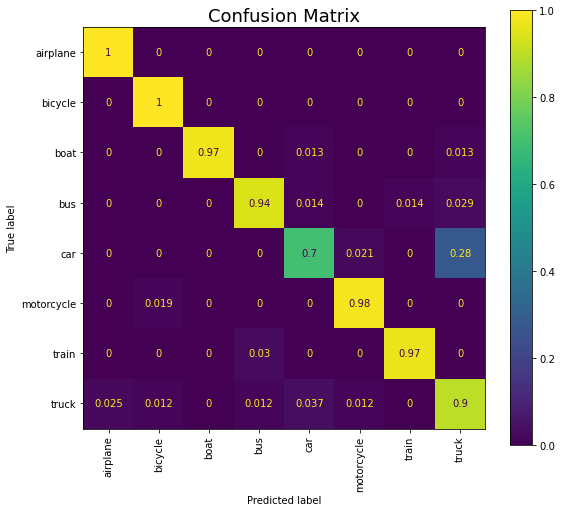

In [21]:
fig, ax = plt.subplots(figsize=(9,8))
cm = confusion_matrix(y_test, test_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
ax.set_title("Confusion Matrix",fontsize=18)
disp.plot(xticks_rotation='vertical',ax=ax)
#fig.savefig('confusion_matrix.jpg')